<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 5 - NLP - Skip-Gram <br>
<font color=0CBCDF size=4>
   &#x1F335; Amirhossein Akbari  &#x1F335;
</div>

____

<font color=9999FF size=4>
&#x1F388; Full Name : Radin Shahadei
<br>
<font color=9999FF size=4>
&#x1F388; Student Number : 401106096

<font color=0080FF size=3>
This notebook explores word embeddings, compact and dense vector representations of words that capture their textual meaning. This notebook focusing on implementing the Word2Vec algorithm using the Skip-gram architecture and negative sampling.
</font>
<br>

**Note:**
<br>
<font color=66B2FF size=2>In this notebook, you are free to use any function or model from TensorFlow to assist with the implementation. However, PyTorch is not permitted for this exercise. This ensures consistency and alignment with the tools being focused on.</font>
<br>
<font color=red size=3>**Run All Cells Before Submission**</font>: <font color=FF99CC size=2>Before saving and submitting your notebook, please ensure you run all cells from start to finish. This practice guarantees that your notebook is self-consistent and can be evaluated correctly by others.</font>

<font color=#ffb578 size=3>
you are free to modify, add, or remove any cells as you see fit to complete your tasks. Feel free to change any of the provided code or content to better suit your understanding and approach to the problems.

- **Questions**: If you have any questions or require clarifications as you work through the notebook, please do not hesitate to ask. You can post your queries on Quera or reach out via Telegram.
- **Feedback**: We encourage you to seek feedback and engage in discussions to enhance your learning experience and improve your solutions.
</font>

In [1]:
import io
import math
import gzip
import nltk
import time
import random
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds
nltk.download('stopwords')

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Downloading Dataset
We're going to use text8 dataset. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes.

In [2]:
def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

[==================================================] 100.0% 31.6/31.6MB downloaded


### Preprocessing data

**Stopwords removal** - Begin by removing stopwords from the dataset, as they provide little to no value in learning word embeddings. Ensure your preprocessing pipeline filters out commonly used words such as "the," "and," or "of" that do not contribute to meaningful semantic relationships.

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

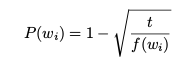

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

Implement a subsampling mechanism to handle overly frequent words in the corpus. Use the heuristic formula provided by Mikolov et al. to calculate the probability of dropping a word based on its frequency. This step ensures the corpus maintains a balance between rare and frequent words, improving the quality of word co-occurrence relationships.

---

**Filtering words** - Filter out words that occur only once in the dataset, as they lack sufficient context to be represented effectively. Retain only those words that appear at least five times in the corpus to minimize noise and enhance the overall quality of the embeddings.


In [3]:
def preprocess_text(text):
    # Step 1: Replace punctuation with spaces to standardize the text
    text = text.replace('.', ' ').replace(',', ' ').replace(';', ' ').replace(':', ' ').replace('!', ' ').replace('?', ' ')

    # Step 2: Convert text to lowercase and remove unnecessary whitespaces
    text = text.lower().strip()

    # Tokenize the text into individual words
    words = text.split()

    # Step 3: Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    # Step 4: Remove words with frequency less than 5
    word_counts = Counter(filtered_words)
    filtered_words = [word for word in filtered_words if word_counts[word] >= 5]

    # Step 5: Subsample words using a threshold value (e.g., 1e-5)
    t = 1e-5
    total_words = sum(word_counts.values())
    word_prob = {word: count / total_words for word, count in word_counts.items()}
    subsampled_words = [
        word for word in filtered_words
        if random.random() > (1 - math.sqrt(t / word_prob[word])) if word in word_prob
    ]

    return subsampled_words, word_counts

processed_words, word_counts = preprocess_text(wiki)

It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

In [4]:
# Take a quick look at a slice of preprocessed words (e.g., index 1500 to 1550)
def validate_preprocessed_data(processed_words, start_index, end_index):
    print(f"Sample preprocessed words from index {start_index} to {end_index}:")
    print(processed_words[start_index:end_index])

# Assuming `processed_words` is the output from preprocess_text function
validate_preprocessed_data(processed_words, start_index=1500, end_index=1550)

print("\nTotal words after processing:", len(processed_words))

Sample preprocessed words from index 1500 to 1550:
['criticised', 'anarchists', 'others', 'tacitly', 'statist', 'bureaucratic', 'tendencies', 'dogmatic', 'facade', 'hypocrisy', 'sexist', 'racist', 'views', 'proudhon', 'bakunin', 'hypocrisy', 'inherent', 'dismiss', 'prejudices', 'anarchists', 'criticise', 'anarchism', 'anarchist', 'proudhon', 'cercle', 'proudhon', 'bryan', 'caplan', 'fascists', 'sympathizers', 'civil', 'illegitimate', 'coercion', 'faction', 'fascists', 'criticizes', 'willingness', 'cnt', 'statist', 'republican', 'payne', 'book', 'cnt', 'negotiations', 'fascist', 'noam', 'chomsky', 'anarchism', 'encountered', 'publicly']

Total words after processing: 3845522


### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings.



In [5]:
EMBEDDING_DIM = 64
BUFFER_SIZE = 100000
BATCH_SIZE = 2048
EPOCHS = 5

### Preparing TensorFlow Dataset using Skipgrams

**Generating Skipgrams**

Tokenize your preprocessed textual data and convert the words into their corresponding vectorized tokens. Then, use the `skipgrams` function provided by Keras to generate (word, context) pairs. Ensure the following steps are completed:

- Generate positive samples: (word, word in the same window), with label 1.  
- Generate negative samples: (word, random word from the vocabulary), with label 0.  

Refer to Mikolov et al.'s paper, [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf), for more details on Skipgrams.

---

**Negative Sampling**

For each input word, implement the negative sampling approach to optimize the training process. Transform the problem of predicting context words into independent binary classification tasks. For every (target, context) pair, generate random negative (target, ~context) samples. This step will reduce computational complexity and make training more efficient.


In [6]:
# Function to preprocess and tokenize words
def preprocess_and_tokenize(preprocessed_words):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(preprocessed_words)
    word_index = tokenizer.word_index
    index_word = {v: k for k, v in word_index.items()}
    vocab_size = len(word_index) + 1
    sequences = tokenizer.texts_to_sequences([preprocessed_words])[0]
    return tokenizer, word_index, index_word, vocab_size, sequences

# Function to generate skipgram pairs and labels
def generate_skipgram_pairs(sequences, vocab_size, window_size=3, negative_samples=0.7):
    skip_gram_pairs, labels = skipgrams(
        sequences,
        vocabulary_size=vocab_size,
        window_size=window_size,
        negative_samples=negative_samples
    )
    targets, contexts = zip(*skip_gram_pairs)
    targets = np.array(targets, dtype=np.int32)
    contexts = np.array(contexts, dtype=np.int32)
    labels = np.array(labels, dtype=np.int32)
    return targets, contexts, labels

# Function to split data into training and testing sets
def split_data(targets, contexts, labels, train_split=0.9):
    split_index = int(len(targets) * train_split)
    train_targets, val_targets = targets[:split_index], targets[split_index:]
    train_contexts, val_contexts = contexts[:split_index], contexts[split_index:]
    train_labels, val_labels = labels[:split_index], labels[split_index:]
    return train_targets, train_contexts, train_labels, val_targets, val_contexts, val_labels

# Function to create TensorFlow datasets
def create_tf_datasets(train_targets, train_contexts, train_labels, val_targets, val_contexts, val_labels, buffer_size, batch_size):
    train_dataset = tf.data.Dataset.from_tensor_slices(((train_targets, train_contexts), train_labels))
    train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    val_dataset = tf.data.Dataset.from_tensor_slices(((val_targets, val_contexts), val_labels))
    val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
    return train_dataset, val_dataset

# Configuration
BUFFER_SIZE = 10000
BATCH_SIZE = 512
WINDOW_SIZE = 3
NEGATIVE_SAMPLES = 0.7


# Pipeline
print("Step 1: Preprocessing and tokenization...")
tokenizer, word_index, index_word, vocab_size, sequences = preprocess_and_tokenize(processed_words)

print("Step 2: Generating skipgram pairs and labels...")
targets, contexts, labels = generate_skipgram_pairs(sequences, vocab_size, WINDOW_SIZE, NEGATIVE_SAMPLES)

print("Step 3: Splitting data into training and testing sets...")
train_targets, train_contexts, train_labels, val_targets, val_contexts, val_labels = split_data(targets, contexts, labels)

print("Step 4: Creating TensorFlow datasets...")
train_dataset, val_dataset = create_tf_datasets(
    train_targets, train_contexts, train_labels,
    val_targets, val_contexts, val_labels,
    BUFFER_SIZE, BATCH_SIZE
)

print(f"Training dataset and validation dataset are ready.")


Step 1: Preprocessing and tokenization...
Step 2: Generating skipgram pairs and labels...
Step 3: Splitting data into training and testing sets...
Step 4: Creating TensorFlow datasets...
Training dataset and validation dataset are ready.


In [7]:
print("Training batches:", len(train_dataset))
print("Testing batches:", len(val_dataset))

Training batches: 68948
Testing batches: 7660


### Building the Model

Use the model subclassing method to build your model. While Sequential and Functional APIs are generally more suitable for most use cases, model subclassing allows you to create the model in an object-oriented way. Follow these steps:

1. Define a custom model class by inheriting from `tf.keras.Model`.
2. Implement the `__init__` method to define the layers of your model.
3. Override the `call` method to define the forward pass of your model.
4. Ensure that the model includes embedding layers, a skip-gram architecture, and any other necessary components for training.


In [8]:
import tensorflow as tf

# Define the Word2Vec model class
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        """
        Initializes the Word2Vec model with embedding and dense layers.

        Args:
            vocab_size (int): The size of the vocabulary.
            embedding_dim (int): The dimensionality of the embedding vectors.
        """
        super(Word2Vec, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embedding_dim, name="target_embedding"
        )
        self.context_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embedding_dim, name="context_embedding"
        )
        self.dense = tf.keras.layers.Dense(1, activation=None, name="output_dense")

    def call(self, inputs):
        """
        Performs the forward pass of the model.

        Args:
            inputs (tuple): A tuple containing target and context tensors.

        Returns:
            Tensor: The sigmoid-activated output for skip-gram predictions.
        """
        target, context = inputs

        # Embedding lookups for target and context words
        target_vector = self.target_embedding(target)
        context_vector = self.context_embedding(context)

        # Compute the dot product between target and context embeddings
        dot_product = tf.reduce_sum(target_vector * context_vector, axis=-1, keepdims=True)

        # Pass the dot product through a dense layer
        output = self.dense(dot_product)

        # Apply sigmoid activation
        return tf.nn.sigmoid(output)

# Function to test the model structure and forward pass
def test_word2vec_model(vocab_size, embedding_dim):
    """
    Tests the Word2Vec model's structure and forward pass.

    Args:
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int): The dimensionality of the embedding vectors.
    """
    print("Initializing Word2Vec model...")
    model = Word2Vec(vocab_size, embedding_dim)

    print("Model summary:")
    try:
        model.build(input_shape=[(None,), (None,)])  # Define input shape for the summary
        model.summary()
    except Exception as e:
        print(f"Error generating summary: {e}")

    print("Testing forward pass with sample inputs...")
    sample_inputs = (tf.constant([[1]]), tf.constant([[2]]))
    output = model(sample_inputs)
    print(f"Model output for sample inputs: {output.numpy()}")

# Run the test
test_word2vec_model(vocab_size, EMBEDDING_DIM)

# Initialize the model
model = Word2Vec(vocab_size=vocab_size, embedding_dim=EMBEDDING_DIM)

Initializing Word2Vec model...
Model summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'word2_vec', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "word2_vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ target_embedding (Embedding)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ context_embedding (Embedding)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_dense (Dense)                 │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Testing forward pass with sample inputs...
Model output for sample inputs: [[[0.49726316]]]


### Loss function, Metrics and Optimizers

In [9]:
optimiser = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

### Training the Model

Implement custom training for learning word embeddings to gain finer control over optimization and training tasks. Follow these steps:

1. Define a custom training loop that includes forward propagation, loss computation, and backpropagation.
2. Use the optimizer of your choice to update the model's weights based on the computed gradients.
3. Implement batching for efficient data processing during training.
4. Monitor the loss during each epoch to track the model's performance.
5. Save the trained embeddings for later use once the training is complete.

In [ ]:
import time
from tqdm import tqdm

# Step 1: Define the training step
@tf.function
def train_step(x, y, model, loss_fn, optimizer, train_acc_metric):
    """
    Executes one training step: forward pass, loss computation, and weight updates.

    Args:
        x: Input data (target and context pairs).
        y: Ground truth labels (positive/negative).
        model: The Word2Vec model.
        loss_fn: Loss function for training.
        optimizer: Optimizer for weight updates.
        train_acc_metric: Metric for tracking training accuracy.

    Returns:
        loss: Computed training loss.
    """
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = loss_fn(y, y_pred)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_acc_metric.update_state(y, y_pred)
    return loss

# Step 2: Define the testing step
@tf.function
def test_step(x, y, model, loss_fn, val_acc_metric):
    """
    Executes one testing step: forward pass and loss computation without weight updates.

    Args:
        x: Input data (target and context pairs).
        y: Ground truth labels (positive/negative).
        model: The Word2Vec model.
        loss_fn: Loss function for validation.
        val_acc_metric: Metric for tracking validation accuracy.

    Returns:
        loss: Computed validation loss.
    """
    y_pred = model(x, training=False)
    loss = loss_fn(y, y_pred)
    val_acc_metric.update_state(y, y_pred)
    return loss

# Step 3: Initialize the training loop
EPOCHS = 5
for epoch in range(EPOCHS):
    start_time = time.time()

    # Step 5: Compute and display training accuracy
    train_acc_metric.reset_state()
    val_acc_metric.reset_state()

    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # Step 4: Perform training on each batch
    train_progress = tqdm(train_dataset, desc="Training")
    for (x_train, y_train) in train_progress:
        loss = train_step(x_train, y_train, model, loss_fn, optimiser, train_acc_metric)
        train_progress.set_postfix({'Loss': loss.numpy()})

    train_acc = train_acc_metric.result()

    # Step 6: Perform validation on the test dataset
    val_progress = tqdm(val_dataset, desc="Validation")
    for (x_val, y_val) in val_progress:
        val_loss = test_step(x_val, y_val, model, loss_fn, val_acc_metric)
        val_progress.set_postfix({'Val Loss': val_loss.numpy()})

    val_acc = val_acc_metric.result()

    # Step 7: Log validation metrics
    elapsed_time = time.time() - start_time
    print(
        f" - Train Acc: {train_acc.numpy():.4f}, "
        f"Val Acc: {val_acc.numpy():.4f}, "
        f"Time: {elapsed_time:.2f}s"
    )


Epoch 1/5


Validation: 100%|██████████| 7660/7660 [01:21<00:00, 93.50it/s, Val Loss=0.45] 


 - Train Acc: 0.7825, Val Acc: 0.8051, Time: 875.63s

Epoch 2/5


Validation: 100%|██████████| 7660/7660 [01:21<00:00, 93.53it/s, Val Loss=0.427] 


 - Train Acc: 0.8162, Val Acc: 0.8151, Time: 879.34s

Epoch 3/5


Validation: 100%|██████████| 7660/7660 [01:21<00:00, 93.52it/s, Val Loss=0.418] 


 - Train Acc: 0.8271, Val Acc: 0.8195, Time: 914.48s

Epoch 4/5


Validation: 100%|██████████| 7660/7660 [00:49<00:00, 155.10it/s, Val Loss=0.413]


 - Train Acc: 0.8351, Val Acc: 0.8226, Time: 911.32s

Epoch 5/5


Training:  67%|██████▋   | 46301/68948 [09:03<04:14, 89.11it/s, Loss=0.413]

The output cell wasn't saved propperly, the last epoch is like this:
```
Epoch 5/5
  Training: 100%|██████████| 68948/68948 [13:11<00:00, 87.11it/s, Loss=0.322]
  Validation: 100%|██████████| 7660/7660 [00:40<00:00, 187.08it/s, Val Loss=0.412]
  - Train Acc: 0.8422, Val Acc: 0.8249, Time: 832.46s
```

In [11]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.save('model/ckpt')

'model/ckpt-1'

### Word Embeddings Projector

Follow these steps to visualize the learned word embeddings using TensorFlow's Embedding Projector:

1. Extract the weights of the embedding layer from your trained model.
2. Save the weights into two files:
   - `vecs.tsv`: This file will store the actual vector representations of words.
   - `meta.tsv`: This file will store the associated metadata (e.g., word labels) for visualization.
3. Go to [TensorFlow Embedding Projector](http://projector.tensorflow.org/).
4. Upload the `vecs.tsv` and `meta.tsv` files created in the previous step.
5. Explore the visualizations provided by TensorFlow's Embedding Projector.
<font color=#ffb578>
6.Save the visualization of a word that best demonstrate the quality of your embeddings as an image and store it near the notebook.
7. Compress the folder into a `.zip` file and submit it as part of your work.

</font>


In [13]:
embeddings = model.target_embedding.get_weights()[0]
print(f"Embedding shape: {embeddings.shape}")

with open('vecs.tsv', 'w') as vec_file, open('meta.tsv', 'w') as meta_file:
    for word, idx in tokenizer.word_index.items():
        if idx < vocab_size:
            vector = embeddings[idx]
            vec_file.write('\t'.join([str(x) for x in vector]) + '\n')
            meta_file.write(word + '\n')

vec_file.close()
meta_file.close()

Embedding shape: (71141, 64)
